# VTA Demo

加载前端模型：

In [1]:
import torch
import torchvision

model_name = "resnet18"
model = torchvision.models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights.DEFAULT)
model = model.eval()

# 跟踪以获取 TorchScripted 模型
input_shape = [1, 3, 224, 224]
scripted_model = torch.jit.trace(model, torch.randn(input_shape)).eval()

利用给定的输入规范将 graph 编译为 llvm 目标：

In [2]:
%cd ..
import set_env

/media/pc/data/lxw/ai/tvm-book/doc/tutorials


加载测试图片：

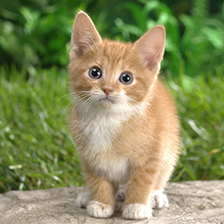

In [3]:
from PIL import Image
from tvm.contrib.download import download_testdata
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
im = Image.open(img_path).resize((224, 224))
im

预处理：

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [19]:
import numpy as np

dtype = "float32"
data = (np.array(im)/256).astype(dtype=dtype)
data -= mean
data /= std
data = data.transpose((2, 0, 1)) # HWC => CHW
data = np.expand_dims(data, axis=0) # CHW => NCHW
shape = data.shape
print(f"data shape: {shape}")

data shape: (1, 3, 224, 224)


加载模型：

In [27]:
import tvm
from tvm import relay

input_name = "data"
shape = 1, 3, 224, 224
shape_list = [(input_name, shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)
m = tvm.contrib.graph_executor.GraphModule(lib["default"](dev))
# 推理
m.run(**{input_name: data})
# 获取输出
float_output = m.get_output(0).numpy()

In [25]:
with torch.no_grad():
    torch_img = torch.from_numpy(data)
    output = model(torch_img).numpy()
# 验证浮点模型数值一致性
np.testing.assert_allclose(output, float_output, rtol=1e-07, atol=1e-5)

## resnet18 模型量化

In [ ]:
with tvm.transform.PassContext(opt_level=3):
    with relay.quantize.qconfig(calibrate_mode="kl_divergence",
                                skip_conv_layers=[]):
        mod = relay.quantize.quantize(mod, params=params)

tvm.ir.transform.PassContext

In [32]:
relay.quantize.qconfig?

Signature: relay.quantize.qconfig(**kwargs)
Docstring:
Configure the quantization behavior by setting config variables.

Parameters
---------
nbit_dict: dict of QAnnotateKind -> int
    Number of bit for every kind of annotate field.

calibrate_mode: str
    The calibration mode. 'global_scale' or 'kl_divergence'.
    global_scale: use global scale
    kl_divergence: find scales by kl divergence on the dataset.

global_scale: float
    The global scale for calibration.

weight_scale: str
    The way to calculate scales for weights (annotated with QAnnotateKind.WEIGHT).
    power2: Find the maximum of the absolute value of the tensor, and then round up to power
    of two.
    max: Find the maximum of the absolute value of the tensor

skip_dense_layer: boolean
    Whether to skip all nn.dense layer type. By default are skipped.

skip_conv_layers: list
    Specifying which layers to be skipped. Provide a list of indices
    that indicate which conv2d layers to leave untouched. Start from